# Toy examples using Stan (1949+)


This time using data previous 1949. 

In [1]:
# libraries
library(rstan)
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())
library(brms)
library(loo)
library(haven)
library(data.table)
#library(sdazar)
library(MASS)
library(ggplot2)

options(repr.plot.width = 7, repr.plot.height = 4)
source('Rutils/functions.R')

Warning message:
“package ‘rstan’ was built under R version 3.4.3”Loading required package: ggplot2
Loading required package: StanHeaders
Warning message:
“package ‘StanHeaders’ was built under R version 3.4.3”rstan (Version 2.17.3, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
Loading required package: Rcpp
Warning message:
“package ‘Rcpp’ was built under R version 3.4.3”Loading 'brms' package (version 1.8.0.1). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').
Plotting theme set to bayesplot::theme_default().
This is loo version 1.1.0


## Using real data (1949 or less)

In [2]:
# load data

df = data.table(read_stata('../data/LA_uncertainty.dta'))

df = df[, .(ctry, year, gdp_pc, median)]
setnames(df, c('gdp_pc', 'median'), c('gdp', 'le'))
df = df[complete.cases(df)]

df[, tle := le/(1.05*max(le))]

df49 = copy(df)[year < 1950]
df50 = copy(df)[year >= 1950]

# using >=50
data = list(
    N = nrow(df49),
    x = df49$gdp, 
    y = df49$tle
)

saveRDS(data, '../data/example49.rds')

# Preston Model

## Frequentist

In [5]:
# estimating starting values for the parameters. 
# Assume alpha=1, then estimate logit(yvar)=beta+gamma^GDP

In [3]:
pars = nls(log(y) ~ beta+exp(log(C)*x),
      data=data,
      start=list(beta=1,C=1))

In [4]:
nlsFormula = "y ~ alpha / (1 + exp( beta + exp(log(C) * x )))"
nlsInitial = c(alpha=max(data$y),coef(pars)[1],coef(pars)[2])

In [5]:
model_preston = minpack.lm::nlsLM(formula = nlsFormula,
         data=data,
         start=nlsInitial,
     control=minpack.lm::nls.lm.control(maxiter=1024))

In [6]:
summary(model_preston)


Formula: y ~ alpha/(1 + exp(beta + exp(log(C) * x)))

Parameters:
       Estimate Std. Error  t value Pr(>|t|)    
alpha 3.917e+01  2.901e+03    0.014    0.989    
beta  3.741e+00  7.460e+01    0.050    0.960    
C     9.998e-01  2.108e-04 4743.912   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.07797 on 100 degrees of freedom

Number of iterations till stop: 94 
Achieved convergence tolerance: 1.49e-08
Reason stopped: Number of calls to `fcn' has reached or exceeded `maxfev' == 400.


## Stan

In [44]:
stan_preston = '
    data {
      int<lower=0> N; 
      real x[N]; 
      real y[N]; 
    } 
    parameters {
      real alpha; 
      real beta;  
      real<lower=0, upper= 1> C;
      real<lower=0> sigma; 
    } 
    model {
      alpha ~ normal(0,2); 
      beta ~ normal(0,2); 
      C ~ uniform(0,1); 
      
      for (i in 1:N) {
        y[i] ~ normal(alpha / ( 1 + exp ( beta + exp ( log(C) * x[i]))), sigma);
      }

      }
    generated quantities{
      real y_pred[N];
      real log_lik[N];

      for(i in 1:N){
        y_pred[i] = normal_rng(alpha / ( 1 + exp ( beta + exp (log(C) * x[i]))), sigma);   
        log_lik[i] = normal_lpdf(y[i] | alpha / ( 1 + exp ( beta + exp (log(C) * x[i]))), sigma); // no need of adjustment
     }
    }
'

In [45]:
fit_preston = stan(model_code = stan_preston, 
            model_name = "preston", 
            data = data, 
            control = list(adapt_delta=0.95))

In [24]:
#pairs(fit_preston, pars=c('alpha', 'beta', 'C'))

In [46]:
print(fit_preston, pars=c('alpha', 'beta', 'C', 'sigma'))

Inference for Stan model: preston.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

      mean se_mean   sd  2.5%  25%  50%  75% 97.5% n_eff Rhat
alpha 2.15    0.03 0.98  0.94 1.39 1.91 2.68  4.57   909 1.01
beta  0.62    0.02 0.53 -0.39 0.23 0.63 1.01  1.58  1110 1.01
C     1.00    0.00 0.00  1.00 1.00 1.00 1.00  1.00  1085 1.00
sigma 0.08    0.00 0.01  0.07 0.08 0.08 0.08  0.09  1969 1.00

Samples were drawn using NUTS(diag_e) at Tue Feb 20 09:04:48 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [47]:
# leave-one-out
loo(extract_log_lik(fit_preston, parameter_name = 'log_lik'))

Computed from 4000 by 103 log-likelihood matrix

         Estimate   SE
elpd_loo    113.9  7.4
p_loo         3.2  0.6
looic      -227.8 14.8

All Pareto k estimates are good (k < 0.5)
See help('pareto-k-diagnostic') for details.

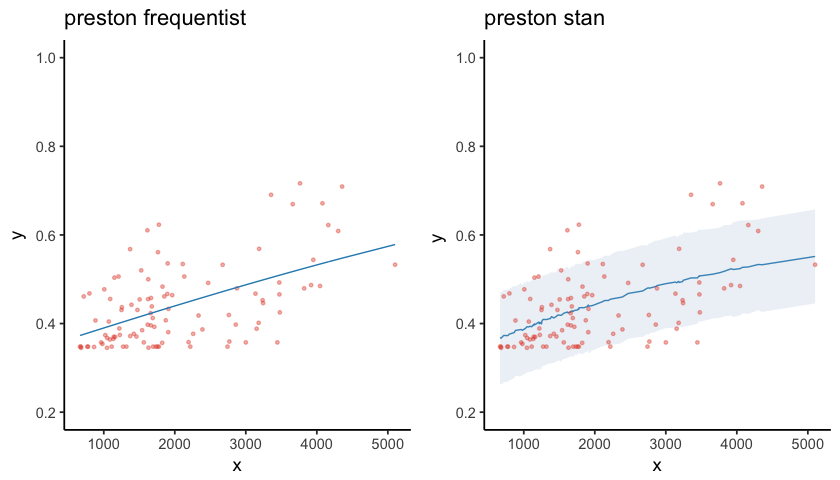

In [48]:
# plots
options(repr.plot.width = 7, repr.plot.height = 4)

plot1 = plot_predictions(data$x,data$y, pred=predict(model_preston)) + ylim(0.2, 1.0) +
    labs(title='preston frequentist')
plot2 = plot_posterior(fit_preston, data$x, data$y) + labs(title='preston stan') +  ylim(0.2, 1.0)
gridExtra::grid.arrange(plot1, plot2, ncol=2)

More differences in the final estimates and fit between the frequentist and bayesian approach. Smaller the data, greater the effect of prios. We can force to be similar just providing informative priors but I don't know if it is a good idea. 

# Boxcox

## Frequentist

In [6]:
bc = boxcox(data$y~log(data$x),plotit=FALSE,lambda=seq(-4,4,0.01))

In [7]:
lambda = bc$x[bc$y==max(bc$y)]

In [8]:
lambda

[1] -1.91

In [9]:
if(lambda==0) {y = log(data$y)}
if(lambda!=0) {y = (data$y^lambda -1)/lambda}
model_bc = lm(y ~ log(data$x))

In [10]:
summary(model_bc)


Call:
lm(formula = y ~ log(data$x))

Residuals:
     Min       1Q   Median       3Q      Max 
-1.55176 -0.49889 -0.07675  0.55529  1.52075 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -8.9771     1.1525  -7.789 6.12e-12 ***
log(data$x)   0.8984     0.1534   5.857 5.90e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.776 on 101 degrees of freedom
Multiple R-squared:  0.2536,	Adjusted R-squared:  0.2462 
F-statistic: 34.31 on 1 and 101 DF,  p-value: 5.905e-08


## Stan

In [11]:
stan_boxcox = '
    data {
        int<lower=0> N;
        real x[N]; 
        real y[N]; 
    }

    parameters {
        real alpha;
        real beta;
        real lambda;
        real<lower=0> sigma;
    }

    model {
        lambda ~ normal(0,2);
        beta ~ normal(0,2);
        alpha ~ normal(0,2);

        if (lambda == 0) {
            for(i in 1:N) {
                    log(y[i]) ~ normal(alpha + log(x[i])*beta, sigma);
                    target += -log(y[i]);
            }
        } else {
            for(i in 1:N){
                    (y[i]^lambda - 1)/lambda ~ normal(alpha + log(x[i])*beta, sigma);
                    target += (lambda - 1)*log(y[i]);
                }
            }
        }

    generated quantities {

       real y_pred[N];
       real log_lik[N];
       int i;

    for(n in 1:N){
           if(lambda != 0) {
             
            // this is crude and potentially problematic solution!
            // discarding problematic posterior values

             i = 1;
             while ((is_nan(y_pred[n])) && (i <= 5000)) {
                y_pred[n] = ((normal_rng(alpha + log(x[n])*beta, sigma)) * lambda + 1)^(1/lambda);
                i = i + 1;
             }

             if (is_nan(y_pred[n])) {
               y_pred[n] = 0; // very crude solution!
             } 
               
            //if(is_nan(y_pred[n])) { // for assessing bugs
                //print(alpha);
                //print(log(x[n]));
                //print(beta);
                //print(sigma);
                //print(lambda);
            //}

             log_lik[n] = normal_lpdf((y[n]^lambda - 1)/lambda | alpha + log(x[n])*beta, sigma) + (lambda-1)*log(y[n]); // is this right?
            //log_lik[n] = normal_lpdf((y[n]^lambda - 1)/lambda | alpha + log(x[n])*beta, sigma);
            
            } else {
             y_pred[n] = exp(normal_rng(alpha + log(x[n])*beta, sigma));
             log_lik[n] = normal_lpdf(log(y[n]) | alpha +  log(x[n])*beta, sigma) - log(y[n]); // this is right!
            //log_lik[n] = normal_lpdf(log(y[n]) | alpha +  log(x[n])*beta, sigma);

           }
         }
    }
    '

In [ ]:
fit_boxcox = stan(model_code = stan_boxcox, 
            model_name = 'boxcox', 
            data = data, 
            iter = 5000,
            control = list(adapt_delta = 0.99))

In [14]:
print(fit_boxcox, pars=c('alpha', 'beta', 'lambda', 'sigma'))

Inference for Stan model: boxcox.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
alpha  -4.93    0.04 1.12 -7.33 -5.63 -4.87 -4.11 -3.00   675    1
beta    0.45    0.00 0.12  0.24  0.36  0.44  0.52  0.71   738    1
lambda -1.24    0.01 0.34 -1.90 -1.47 -1.24 -1.01 -0.55   633    1
sigma   0.47    0.01 0.14  0.25  0.37  0.45  0.55  0.80   688    1

Samples were drawn using NUTS(diag_e) at Mon Feb 19 21:27:23 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [15]:
loo(extract_log_lik(fit_boxcox, parameter_name = 'log_lik'))

Computed from 4000 by 103 log-likelihood matrix

         Estimate   SE
elpd_loo    128.1  7.9
p_loo         2.7  0.3
looic      -256.3 15.9

All Pareto k estimates are good (k < 0.5)
See help('pareto-k-diagnostic') for details.

The problem of lower posterior values is less severe than for 1950+.

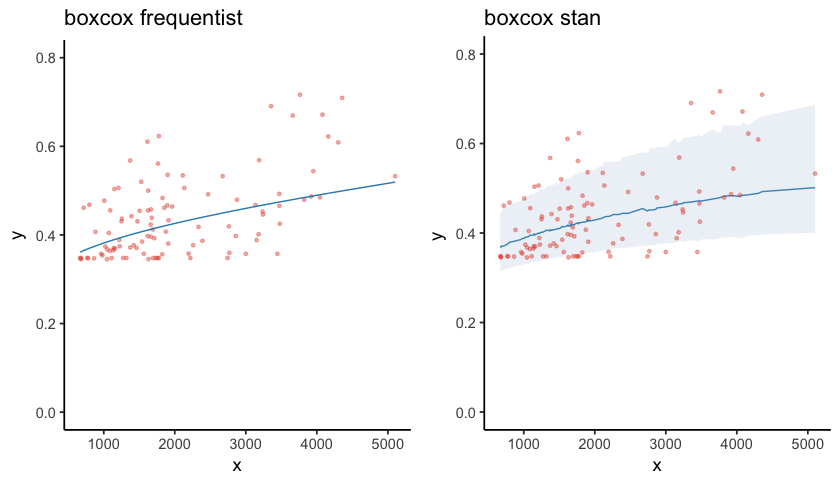

In [16]:
options(repr.plot.width = 7, repr.plot.height = 4)
plot1 = plot_predictions(data$x, data$y, pred_bc(predict(model_bc), lambda=lambda)) + ylim(0, 0.8) + labs(title='boxcox frequentist')
plot2 = plot_posterior(fit_boxcox, data$x, data$y, 'y_pred') + labs(title='boxcox stan') + ylim(0,0.8)
gridExtra::grid.arrange(plot1, plot2, ncol=2)

# Log and quadratic model

Equivalent to the box-cox with lamda = 0.

## Frequentist

In [90]:
model_log = lm(log(data$y) ~ 1 + log(data$x))

In [91]:
summary(model_log)


Call:
lm(formula = log(data$y) ~ 1 + log(data$x))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.31798 -0.10356 -0.03348  0.08472  0.36927 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.32697    0.24786  -9.388 2.00e-15 ***
log(data$x)  0.19844    0.03299   6.016 2.89e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1669 on 101 degrees of freedom
Multiple R-squared:  0.2638,	Adjusted R-squared:  0.2565 
F-statistic: 36.19 on 1 and 101 DF,  p-value: 2.888e-08


## Stan

In [94]:
stan_log = '
    data {
        int<lower=0> N;
        real y[N];
        real x[N];
    }

    parameters {
        real alpha;
        real beta;
        real<lower=0> sigma;
    }

    model {
        beta ~ normal(0,2);
        alpha ~ normal(0,2);

        for (i in 1:N) {
            log(y[i]) ~ normal(alpha + log(x[i])*beta, sigma);
            //target += -log(y[i]);
        }
}

    generated quantities {
       vector[N] y_pred;
       vector[N] log_lik;
        
        for (n in 1:N) {
        log_lik[n] = normal_lpdf(log(y[n]) | alpha +  log(x[n])*beta, sigma) - log(y[n]);
        y_pred[n] = exp(normal_rng(alpha + log(x[n])*beta, sigma));
         }
        }
    '

In [95]:
fit_log = stan(model_code = stan_log, 
            model_name ='log',
            data = data)

In [96]:
print(fit_log, pars=c('alpha', 'beta', 'sigma'))

Inference for Stan model: log.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
alpha -2.29    0.01 0.25 -2.77 -2.46 -2.29 -2.12 -1.78  1261    1
beta   0.19    0.00 0.03  0.12  0.17  0.19  0.22  0.26  1262    1
sigma  0.17    0.00 0.01  0.15  0.16  0.17  0.18  0.20  1306    1

Samples were drawn using NUTS(diag_e) at Fri Feb 16 13:30:07 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [30]:
#traceplot(fit_log, pars=c('alpha', 'beta', 'sigma'))

In [97]:
loo(extract_log_lik(fit_log, parameter_name = 'log_lik'))

Computed from 4000 by 103 log-likelihood matrix

         Estimate   SE
elpd_loo    122.7  7.4
p_loo         2.7  0.4
looic      -245.4 14.8

All Pareto k estimates are good (k < 0.5)
See help('pareto-k-diagnostic') for details.

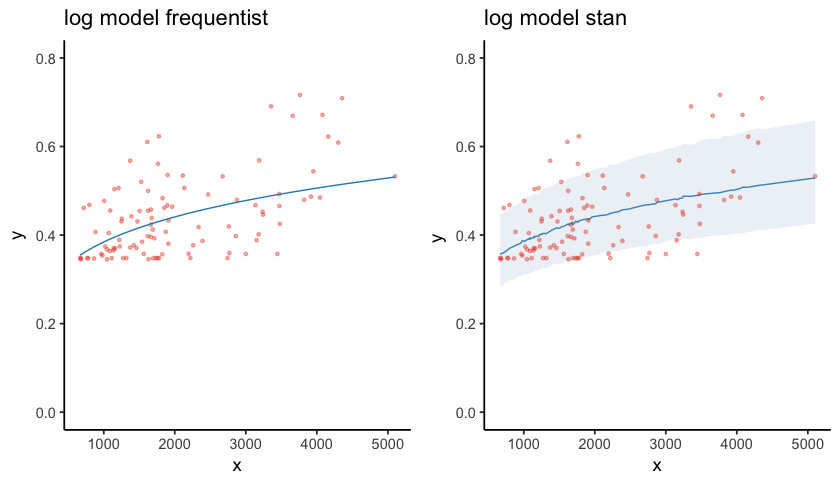

In [100]:
plot1 = plot_predictions(data$x, data$y, exp(predict(model_log))) + ylim(0, 0.8) + labs(title='log model frequentist')
plot2 = plot_posterior(fit_log, data$x, data$y) + labs(title='log model stan') + ylim(0, 0.8)
gridExtra::grid.arrange(plot1, plot2, ncol=2)

# Averaging or stacking

In [101]:
log_lik_list = list()
log_lik_list[[1]] = extract_log_lik(fit_preston, parameter_name = 'log_lik')
log_lik_list[[2]] = extract_log_lik(fit_log, parameter_name = 'log_lik') 
log_lik_list[[3]] = extract_log_lik(fit_boxcox, parameter_name = 'log_lik') 

In [109]:
w = loo::model_weights(log_lik_list, method='stacking')

The stacking weights are:
     [,1]      [,2]      [,3]     
[1,] "Model 1" "Model 2" "Model 3"
[2,] "0"       "0"       "1"      


In [110]:
w = loo::model_weights(log_lik_list, method='pseudobma')

The Pseudo-BMA+ weights using Bayesian Bootstrap  are:
      [,1]      [,2]      [,3]     
[1,] "Model 1" "Model 2" "Model 3"
[2,] "0"       "0.02"    "0.98"   


Difference between  models is pretty strong... averaging is giving weight 1 to one of the models (box-cox), in other words, no need to average but to use the best model!

In [115]:
# get combine predictions using stacking

In [111]:
models = list()
models[[1]] = fit_preston
models[[2]] = fit_log
models[[3]] = fit_boxcox

In [112]:
sum(w) # check weights sum 1

[1] 1

In [118]:
options(repr.plot.width = 4, repr.plot.height = 4)

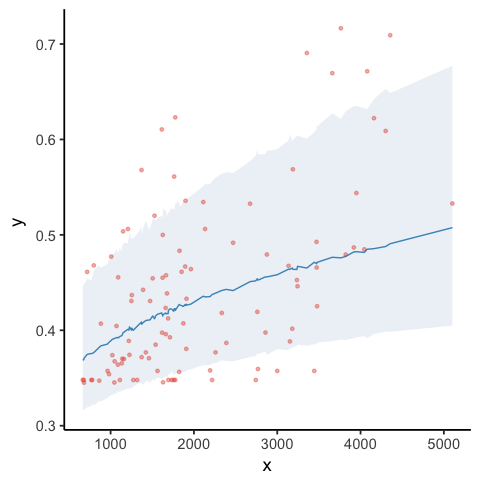

In [119]:
plot_posterior_w(models, w, data$x, data$y)

In [ ]:
# same weight for all models

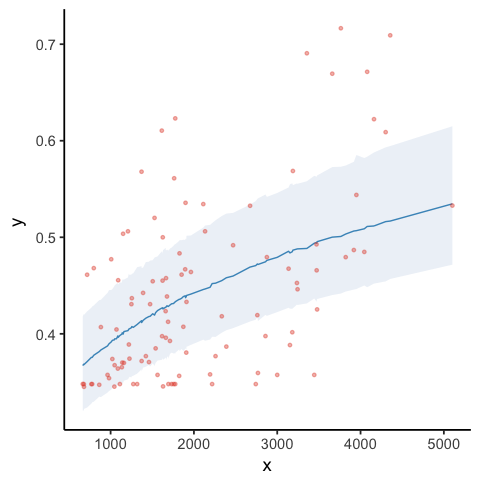

In [120]:
plot_posterior_w(models, rep(1/3, 3), data$x, data$y)